<a href="https://colab.research.google.com/github/bshazia/Apple_Stocks/blob/main/Apple_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install yfinance==0.2.12
!pip install pandas_market_calendars

[link text](https://)**Step 1: Data Collection**

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
import datetime
import pandas_market_calendars as mcal
from tensorflow.keras.layers import Input,LSTM
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


In [10]:
#daily data for past 10 years
data_daily = yf.download("AAPL", period="10y", interval="1d")
data_daily.to_csv('AAPL_daily_data.csv')

#monthly data for past 10 years
data_monthly = yf.download("AAPL", period="10y", interval="1mo")
data_monthly.to_csv('AAPL_monthly_data.csv')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/yfinance/utils.py:517: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quotes.loc[idx2, "High"] = _np.nanmax([quotes["High"][n - 1], quotes["High"][n - 2]])
/usr/local/lib/python3.10/dist-packages/yfinance/utils.py:518: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quotes.loc[idx2, "Low"] = _np.nanmin([quotes["Low"][n - 1], quotes["Low"][n - 2]])
/usr/local/lib/python3.10/dist-packages/yfinance/utils.py:519: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame beha

In [11]:
data_monthly.sample(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-01,66.817497,73.492500,64.072502,73.412498,71.250443,2388794800
2016-05-01,23.492500,25.182501,22.367500,24.965000,22.764904,3602686000
2023-01-01,130.279999,147.229996,124.169998,144.289993,142.945526,1443652500
2021-03-01,123.750000,128.720001,116.209999,122.150002,119.755096,2650418200
2023-04-01,164.270004,169.850006,159.779999,169.679993,168.355621,969709700


In [12]:
data_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2014-08-15 to 2024-08-14
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2516 non-null   float64
 1   High       2516 non-null   float64
 2   Low        2516 non-null   float64
 3   Close      2516 non-null   float64
 4   Adj Close  2516 non-null   float64
 5   Volume     2516 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.6 KB


In [13]:
data_monthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2014-09-01 to 2024-08-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       120 non-null    float64
 1   High       120 non-null    float64
 2   Low        120 non-null    float64
 3   Close      120 non-null    float64
 4   Adj Close  120 non-null    float64
 5   Volume     120 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 6.6 KB


In [14]:
# Check for missing dates in daily data
all_dates_daily = pd.date_range(start=data_daily.index.min(), end=data_daily.index.max(), freq='D')
missing_dates_daily = all_dates_daily.difference(data_daily.index)
print("Missing dates in daily data:", missing_dates_daily)
print("Number of missing dates in daily data:", missing_dates_daily.size)

# Check for missing dates in monthly data
all_dates_monthly = pd.date_range(start=data_monthly.index.min(), end=data_monthly.index.max(), freq='M')
missing_dates_monthly = all_dates_monthly.difference(data_monthly.index)
print("Missing dates in monthly data:", missing_dates_monthly)
print("Number of missing dates in monthly data:", missing_dates_monthly.size)

Missing dates in daily data: DatetimeIndex(['2014-08-16', '2014-08-17', '2014-08-23', '2014-08-24',
               '2014-08-30', '2014-08-31', '2014-09-01', '2014-09-06',
               '2014-09-07', '2014-09-13',
               ...
               '2024-07-13', '2024-07-14', '2024-07-20', '2024-07-21',
               '2024-07-27', '2024-07-28', '2024-08-03', '2024-08-04',
               '2024-08-10', '2024-08-11'],
              dtype='datetime64[ns]', length=1137, freq=None)
Number of missing dates in daily data: 1137
Missing dates in monthly data: DatetimeIndex(['2014-09-30', '2014-10-31', '2014-11-30', '2014-12-31',
               '2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30',
               '2015-05-31', '2015-06-30',
               ...
               '2023-10-31', '2023-11-30', '2023-12-31', '2024-01-31',
               '2024-02-29', '2024-03-31', '2024-04-30', '2024-05-31',
               '2024-06-30', '2024-07-31'],
              dtype='datetime64[ns]', length=119, freq

In [15]:
#lets verify it with market calendar
nyse = mcal.get_calendar('NYSE')
trading_days = nyse.schedule(start_date=data_daily.index.min(), end_date=data_daily.index.max())

non_trading_days = missing_dates_daily[~missing_dates_daily.isin(trading_days.index)]

print("Number of missing dates that are non-trading days:", non_trading_days.size)

Number of missing dates that are non-trading days: 1137


these are non-trading days and it's not impacting our data integrity
\

#lets Predict first on Daily

Closing Price
For this analysis, I'll focuse on the closing price as it is a standard key indicator for predicting future prices, especially in the short term

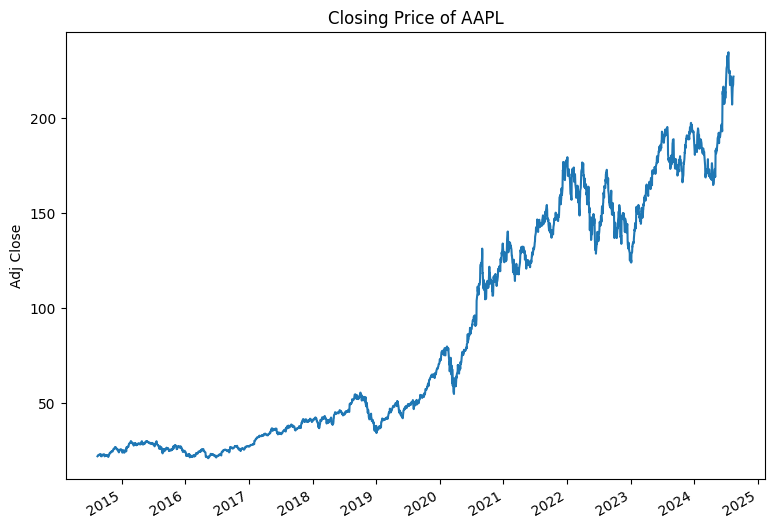

In [16]:
# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

plt.subplot(2, 2, 1)
data_daily_copy['Adj Close'].plot()
plt.ylabel('Adj Close')
plt.xlabel(None)
plt.title(f"Closing Price of AAPL")

plt.tight_layout()

let's check moving average

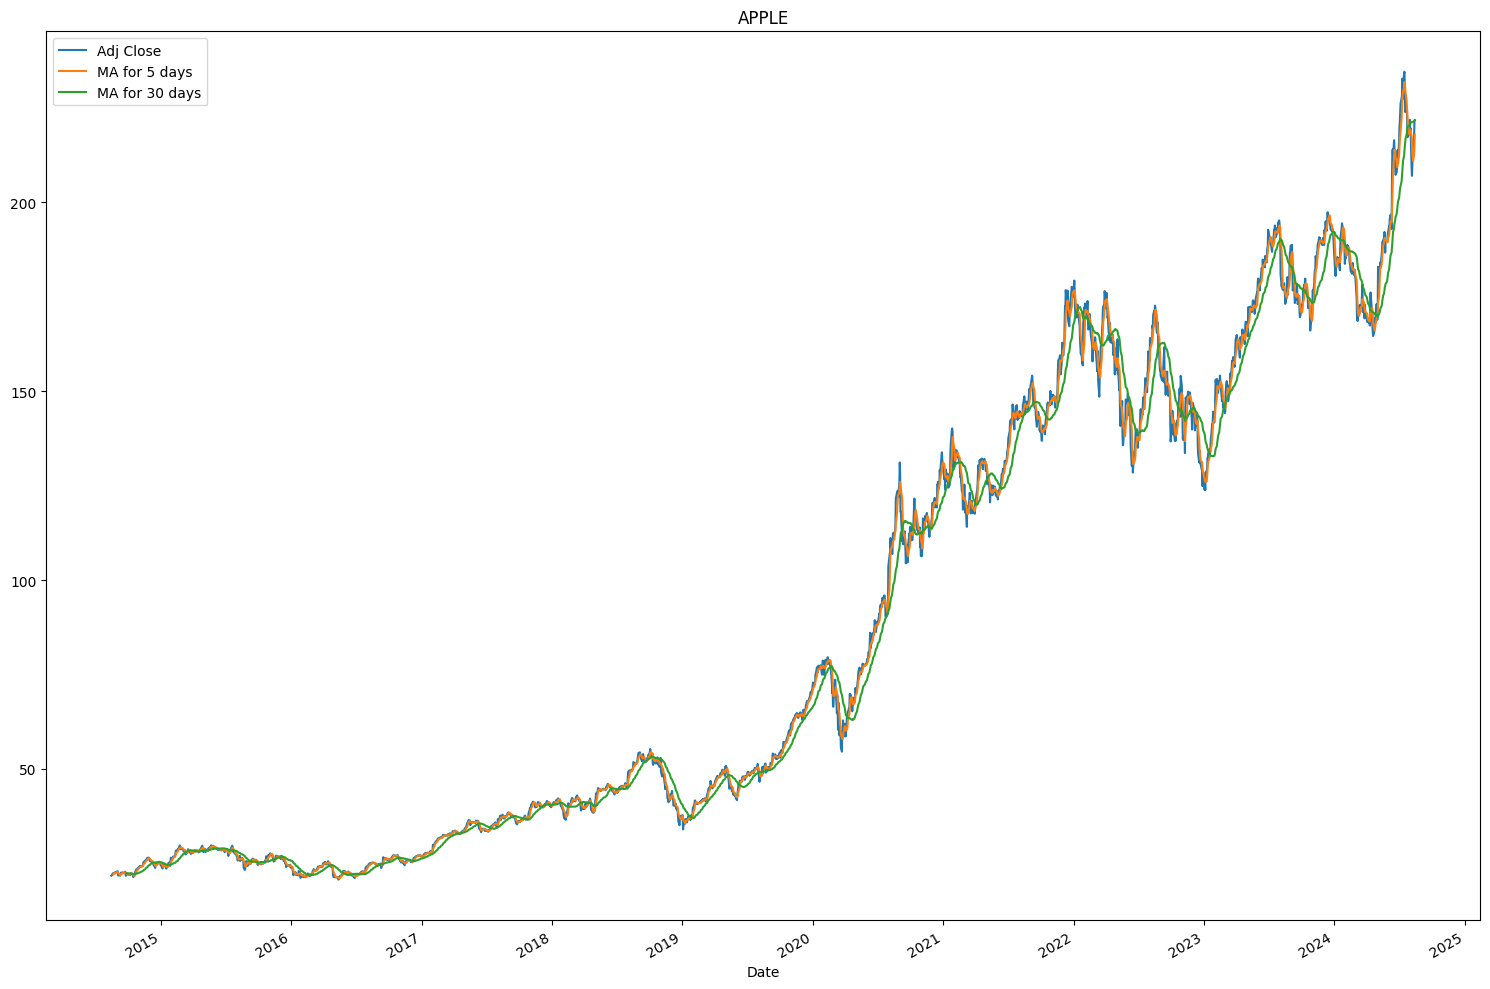

In [17]:
# Calculate moving averages
data_daily['MA for 5 days'] = data_daily['Adj Close'].rolling(window=5).mean()
data_daily['MA for 30 days'] = data_daily['Adj Close'].rolling(window=30).mean()

fig, ax = plt.subplots(figsize=(15, 10))

data_daily[['Adj Close', 'MA for 5 days', 'MA for 30 days']].plot(ax=ax)
ax.set_title('APPLE')

fig.tight_layout()

so this indicates a generally bullish trend, with the price consistently above both short-term and long-term moving averages

In [18]:
data = data_daily.filter(['Close'])
dataset = data.values

training_data_len = len(dataset) - 5

training_data_len

2511

In [19]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00899947],
       [0.01038944],
       [0.01200321],
       ...,
       [0.91853366],
       [0.93615566],
       [0.93827594]])

Training

In [20]:
train_data = scaled_data[0:int(training_data_len), :]

x_train = []
y_train = []

#lookback period LSTM model considers to make a prediction for a single day
for i in range(30, len(train_data)):
    x_train.append(train_data[i-30:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 31:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.00899947, 0.01038944, 0.01200321, 0.01205033, 0.01206211,
       0.01293378, 0.01319293, 0.01242727, 0.01388791, 0.01402926,
       0.01432375, 0.0152661 , 0.01013029, 0.00916438, 0.01016562,
       0.00944708, 0.00901124, 0.01255684, 0.01306335, 0.01333428,
       0.01329894, 0.01239193, 0.01324005, 0.01348741, 0.01250972,
       0.01262751, 0.01448866, 0.01344029, 0.00886989, 0.01226235])]
[0.011508473971250419]

[array([0.00899947, 0.01038944, 0.01200321, 0.01205033, 0.01206211,
       0.01293378, 0.01319293, 0.01242727, 0.01388791, 0.01402926,
       0.01432375, 0.0152661 , 0.01013029, 0.00916438, 0.01016562,
       0.00944708, 0.00901124, 0.01255684, 0.01306335, 0.01333428,
       0.01329894, 0.01239193, 0.01324005, 0.01348741, 0.01250972,
       0.01262751, 0.01448866, 0.01344029, 0.00886989, 0.01226235]), array([0.01038944, 0.01200321, 0.01205033, 0.01206211, 0.01293378,
       0.01319293, 0.01242727, 0.01388791, 0.01402926, 0.01432375,
       0.0152661 , 0.01013029, 0

In [21]:
#Let's uild the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [23]:
# Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

2481/2481 ━━━━━━━━━━━━━━━━━━━━ 86s 32ms/step - loss: 0.0029


In [24]:

test_data = scaled_data[training_data_len - 30: , :]

x_test = []
y_test = dataset[training_data_len:, :]
for i in range(30, len(test_data)):
    x_test.append(test_data[i-30:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


8.622996423758412

<ipython-input-25-7060b44ebf5a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


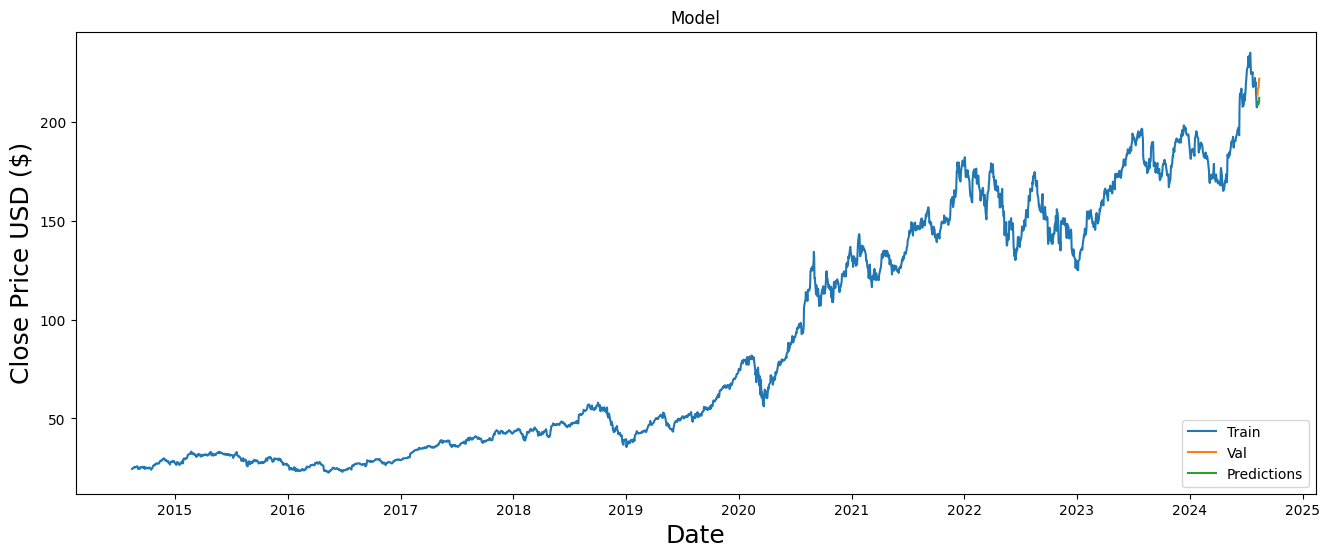

In [25]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')


plt.show()

In [26]:
valid

,Close,Predictions
Date,,
2024-08-08,213.309998,209.018250
2024-08-09,216.240005,208.404099
2024-08-12,217.529999,208.952103
2024-08-13,221.270004,210.110184
2024-08-14,221.720001,212.033005


#Now Lets work on Monthly data

In [27]:
#monthly data for past 10 years
data_monthly = yf.download("AAPL", period="10y", interval="1mo")

[*********************100%***********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/yfinance/utils.py:517: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quotes.loc[idx2, "High"] = _np.nanmax([quotes["High"][n - 1], quotes["High"][n - 2]])
/usr/local/lib/python3.10/dist-packages/yfinance/utils.py:518: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quotes.loc[idx2, "Low"] = _np.nanmin([quotes["Low"][n - 1], quotes["Low"][n - 2]])
/usr/local/lib/python3.10/dist-packages/yfinance/utils.py:519: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame beha

In [28]:
data_monthly.tail(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-11-01,171.000000,192.929993,170.119995,189.949997,188.982956,1099586100
2023-12-01,190.330002,199.619995,187.449997,192.529999,191.802185,1062774800
2024-01-01,187.149994,196.380005,180.169998,184.399994,183.702911,1187219300
2024-02-01,183.990005,191.050003,179.250000,180.750000,180.066711,1161627000
2024-03-01,179.550003,180.529999,168.490005,171.479996,171.049728,1432782800
2024-04-01,171.190002,178.360001,164.080002,170.330002,169.902618,1245717000
2024-05-01,169.580002,193.000000,169.110001,192.250000,191.767624,1336537700
2024-06-01,192.899994,220.199997,192.149994,210.619995,210.376480,1723984500
2024-07-01,212.089996,237.229996,211.919998,222.080002,221.823242,1153099800


In [29]:
features_m = ['High', 'Low', 'Adj Close']
data_m = data_monthly[features_m]

In [40]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data_m = scaler.fit_transform(data_m)

In [41]:
training_data_len_m = len(scaled_data_m) - 6
train_data_m = scaled_data_m[0:training_data_len_m, :]

In [42]:
x_train_month = []
y_train_month = []
for i in range(12, len(train_data_m)):
    x_train_month.append(train_data_m[i-12:i, :])
    y_train_month.append(train_data_m[i, 0])

x_train_month, y_train_month = np.array(x_train_month), np.array(y_train_month)

In [43]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train_month.shape[1], x_train_month.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [44]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [45]:
model.fit(x_train_month, y_train_month, batch_size=1, epochs=1)

102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0329


In [46]:
test_data_m = scaled_data_m[training_data_len_m - 12:, :]
x_test_month = []
for i in range(12, len(test_data_m)):
    x_test_month.append(test_data_m[i-12:i, :])
x_test_month = np.array(x_test_month)

In [47]:
predictions_m = model.predict(x_test_month)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step


In [48]:
predictions_m_reshaped = np.repeat(predictions_m, 3, axis=1)
predictions_m = scaler.inverse_transform(predictions_m_reshaped)

In [49]:
predictions_adj_close = predictions_m[:, 0]

rmse = np.sqrt(np.mean(((predictions_adj_close - data_monthly['Adj Close'][-6:]) ** 2)))
print('RMSE:', rmse)

RMSE: 42.761239279942025


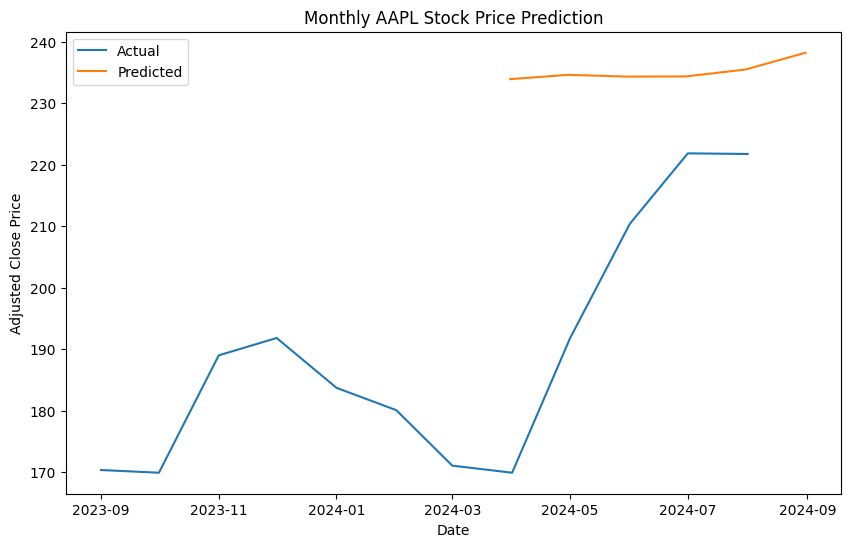

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(data_monthly['Adj Close'][-12:], label='Actual')
plt.plot(pd.date_range(start=data_monthly.index[-6], periods=6, freq='M'), predictions_adj_close, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('Monthly AAPL Stock Price Prediction')
plt.legend()
plt.show()

In [51]:
predictions_df = pd.DataFrame({
    'Date': pd.date_range(start=data_monthly.index[-6], periods=6, freq='M'),
    'Actual': data_monthly['Adj Close'][-6:].values,
    'Predicted': predictions_adj_close
})

predictions_df.set_index('Date', inplace=True)

print(predictions_df)


                Actual   Predicted
Date                              
2024-03-31  171.049728  233.886230
2024-04-30  169.902618  234.584259
2024-05-31  191.767624  234.295731
2024-06-30  210.376480  234.326080
2024-07-31  221.823242  235.455200
2024-08-31  221.720001  238.180481
